In [1]:
from datasets import load_dataset
import os
# import pytorch_lightning as py
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch
import pandas as pd
import gzip
# import glob
import tarfile
from PIL import Image
import io
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy as np
from torchvision import transforms
import torch.nn as nn
from torchsummary import summary
import piq

In [2]:
if torch.cuda.is_available():
    print(f"running cuda on device: {torch.cuda.current_device()}")
    device = torch.device("cuda")    
else:
    print(f"no cuda device found")
    device = torch.device("cpu")    


running cuda on device: 0


# Dataset

In [3]:
class DepthDataSet(data.Dataset):
    def __init__(self,images_path,depth_path,transform=None):
        self.image_path = images_path
        self.depth_path = depth_path
        self.transform = transform

        self.image_files = ([
            f for f in os.listdir(self.image_path)
            if os.path.isfile(os.path.join(self.image_path,f))
            ])
        self.depth_files = ([
            f for f in os.listdir(self.depth_path)
            if os.path.isfile(os.path.join(self.depth_path,f))
            ])

    def __len__(self):
        return len(self.depth_files)
    
    def __getitem__(self, index):
        image_file = self.image_files[index]
        depth_file = self.depth_files[index]
        
        img_path = os.path.join(self.image_path, image_file)
        dpth_path = os.path.join(self.depth_path, depth_file)


        image = Image.open(img_path)
        image = self.transform(image)


        mat_file = loadmat(dpth_path)
        depth = mat_file.get("Position3DGrid")
        depth = depth[:,:,3]
        depth = np.log1p(depth)

        depth = cv.resize(depth, (1704,2272), interpolation=cv.INTER_CUBIC)
        depth = cv.normalize(depth, None, 0, 255, cv.NORM_MINMAX)
        depth = depth.astype(np.uint8)

        depth = np.expand_dims(depth,axis=2)

        depth = torch.from_numpy(depth).permute(2,0,1).float() / 255.0
        return image, depth

        

In [4]:
train_dataset = DepthDataSet(images_path='./data/train/imgs',depth_path='./data/train/depths',transform=transforms.ToTensor())
val_dataset = DepthDataSet(images_path='./data/test/imgs',depth_path='./data/test/depths',transform=transforms.ToTensor())

## Testing dataset

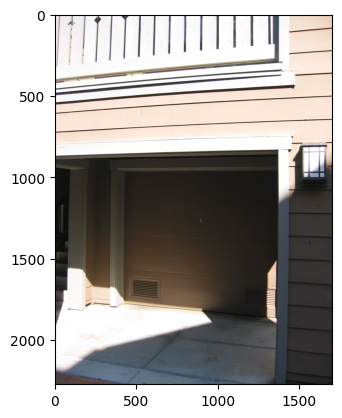

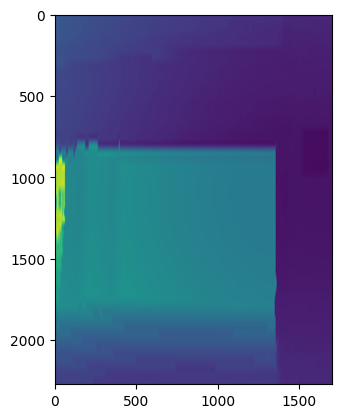

In [8]:
index=47
image,depth = train_dataset[index]
image = image.cpu().permute(1,2,0).numpy()
plt.imshow(image)
plt.show()

depth = depth.cpu().permute(1,2,0).numpy()
plt.imshow(depth)
plt.show()

# Image manipulation

In [5]:
def equalizeDepth(depth):
    depth = depth.cpu().permute(1,2,0).numpy()
    depth = ((depth-depth.min()) / (depth.max()-depth.min())) * 255
    depth = depth.astype(np.uint8)
    depth = cv.equalizeHist(depth)

    depth = np.expand_dims(depth, axis=0)

    depth = torch.tensor(depth)
    depth = depth.float()/255.0

    return depth

In [108]:
def equalizeImage(image):
    image = image.cpu().permute(1,2,0).numpy()

    gamma = .6
    image = np.power(image,gamma)

    # image = image*255
    image = ((image-image.min()) / (image.max()-image.min())) * 255

    # image = (image-np.mean(image)) - np.std(image)

    image = image.astype(np.uint8)

    
    b,g,r = cv.split(image)
    b_eq = cv.equalizeHist(b)
    g_eq = cv.equalizeHist(g)
    r_eq = cv.equalizeHist(r)

    image = cv.merge([b_eq,g_eq,r_eq])


    image = torch.tensor(image).permute(2,0,1)
    image = image.float()/255.0
    return image

## Test manipulation

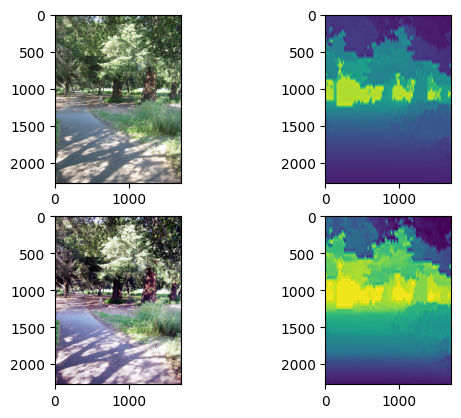

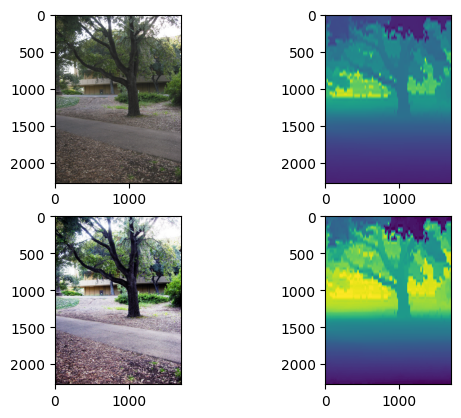

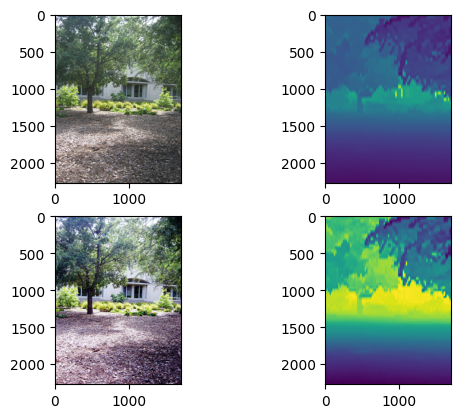

In [109]:
import random
import time
random.seed(time.time())
list = [i for i in range(400)]
indices = random.sample(list,3)
for index in indices:
    image,depth_map = train_dataset[index]
    equalized_image = equalizeImage(image)
    equalized_depth_map = equalizeDepth(depth_map)
    

    fig,axs = plt.subplots(2,2)
    axs[0,0].imshow(image.cpu().permute(1,2,0).numpy())
    axs[1,0].imshow(equalized_image.cpu().permute(1,2,0).numpy())
    

    axs[0,1].imshow(depth_map.cpu().permute(1,2,0).numpy())
    axs[1,1].imshow(equalized_depth_map.cpu().permute(1,2,0).numpy())

    plt.show()

# Dataloader

In [25]:
train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=8,shuffle=True)

# AE Model

In [131]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder,self).__init__()

        #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=2,padding=2),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True)
        )
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12,out_channels=24,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )

        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=24,out_channels=36,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(36),
            nn.ReLU(inplace=True)
        )

        self.encoder_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=36,out_channels=48,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.encoder_conv5 = nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        #decoder
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=48,kernel_size=3,stride=1,padding=1),
            # nn.AdaptiveAvgPool2d((143, 107)),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=48,out_channels=36,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((285,214)),
            nn.BatchNorm2d(36),
            nn.ReLU(inplace=True)
        )

        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=36,out_channels=24,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((569,427)),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )

        self.decoder_conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=24,out_channels=12,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((1137,853)),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True)
        )

        self.decoder_conv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=12,out_channels=1,kernel_size=3,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((2272,1704)),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )


    def forward(self,x):
        encoder_x1 = self.encoder_conv1(x) #12
        encoder_x2 = self.encoder_conv2(encoder_x1) #24
        encoder_x3 = self.encoder_conv3(encoder_x2) #36
        encoder_x4 = self.encoder_conv4(encoder_x3) #48
        encoder_x5 = self.encoder_conv5(encoder_x4) #64

        x = self.decoder_conv1(encoder_x5)
        x = x + encoder_x4
        
        x = self.decoder_conv2(x)
        x = x + encoder_x3

        x = self.decoder_conv3(x)
        x = x = encoder_x2

        x = self.decoder_conv4(x)
        x = x + encoder_x1

        x = self.decoder_conv5(x)

        return x     


In [132]:
encoder_decoder = EncoderDecoder()
encoder_decoder.to(device)

EncoderDecoder(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(24, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_conv4): Sequential(
    (0): Conv2d(36, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_conv5): Sequential(
    (0): Conv2d(48, 64, kernel_size=(3, 3), st

In [133]:
summary(encoder_decoder,(3,2272, 1704))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 12, 1137, 853]             336
       BatchNorm2d-2        [-1, 12, 1137, 853]              24
              ReLU-3        [-1, 12, 1137, 853]               0
            Conv2d-4         [-1, 24, 569, 427]           2,616
       BatchNorm2d-5         [-1, 24, 569, 427]              48
              ReLU-6         [-1, 24, 569, 427]               0
            Conv2d-7         [-1, 36, 285, 214]           7,812
       BatchNorm2d-8         [-1, 36, 285, 214]              72
              ReLU-9         [-1, 36, 285, 214]               0
           Conv2d-10         [-1, 48, 143, 107]          15,600
      BatchNorm2d-11         [-1, 48, 143, 107]              96
             ReLU-12         [-1, 48, 143, 107]               0
           Conv2d-13         [-1, 64, 143, 107]          27,712
      BatchNorm2d-14         [-1, 64, 1

# Training

In [134]:
def save_check(epoch, model, optimizer, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f'Saved model at epoch:{epoch}')

In [135]:
optimizer = torch.optim.Adam(encoder_decoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,gamma=0.5)

In [136]:
def l1_ssim_loss(input1,input2,bias=0.75):
    ssim_loss = piq.ssim(input1,input2,1.0)
    l1_loss = nn.L1Loss()(input1,input2)
    return (l1_loss * bias) + ((1-bias) * ssim_loss)

In [137]:
loss = l1_ssim_loss

In [138]:
def train(encoder_decoder,train_dataloader,val_dataloader,optimizer, criterion, scheduler, epochs=2):
    
    for epoch in range(epochs):
        encoder_decoder.train()
        total_loss = 0.0
        batch_num = 0
        for data,depth_data in train_dataloader:

            batch_num+=1
            
            inputs = data
            ground_truth = depth_data
            # ground_truth = (depth_data - depth_data.min()) / (depth_data.max() - depth_data.min())

            inputs = np.array([equalizeImage(img) for img in inputs])            
            ground_truth = np.array([equalizeDepth(depths) for depths in ground_truth])
            
            inputs = torch.from_numpy(inputs)
            ground_truth = torch.from_numpy(ground_truth)
            
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            optimizer.zero_grad()

            result = encoder_decoder(inputs)
            
            loss = criterion(result,ground_truth)

            loss.backward()

            optimizer.step()
            
            curr_loss = loss.item()
            total_loss+= curr_loss

            torch.cuda.empty_cache()
            print("Batch:{:3d}/{:3d}{:10}Loss{:10f}{:10}{:2d}/{:2d}".format(batch_num,len(train_dataloader),"",curr_loss,"",epoch,epochs))
        scheduler.step()
        filename ="./models/checkpoints"
        save_check(epoch,encoder_decoder,optimizer,criterion,f"{filename}/encoder_decoder_{epoch}.pth")
    
        # encoder_decoder.eval()
        
        
        # val_loss = 0.0
        # with torch.no_grad():
        #     for data, depth_data in zip(val_img_dataloader,val_depth_dataloader):
        #         data = data.to(device)
        #         depth_data = depth_data.to(device)

        #         encoded = encoder(data.to(device))
        #         decoded = decoder(encoded)
    
        #         loss =  criterion(decoded,depth_data)
        #         val_loss += loss.item()

        # val_loss/= len(val_img_dataloader)
        # print("Epoch {:10d}{:10}Train Loss:{:10f}{:10}Val Loss:{:10f}".format(epoch,"",total_loss/len(img_dataloader),"",val_loss)) 

        
        # test_images = next(iter(val_img_dataloader))
        # test_images = test_images.to(device)
    
        # encoded = encoder(test_images)
        # decoded = decoder(encoded)
    
        # decoded = decoded.to("cpu")
        # decoded = decoded.detach()
        # for i in range(decoded.shape[0],1):
        #     plt.imshow(test_images[i].permute(1,2,0))
        #     plt.show()
        #     depth = np.array(decoded[i].permute(1,2,0)*255,dtype=np.uint8)
        #     print(f"mean:{np.mean(depth)}\nvar:{np.var(depth)}\nmax:{np.max(depth)}")
        #     plt.imshow(depth)
        #     plt.show()
            
           

In [139]:
train(encoder_decoder,train_dataloader,val_dataloader,optimizer,loss,scheduler,epochs=5)

KeyboardInterrupt: 

In [113]:
model_name = "equalized_imgs_5_epoch"
torch.save(encoder_decoder,f"./models/saved/{model_name}.pth")

In [114]:
encoder_decoder.eval()

EncoderDecoder(
  (Encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(24, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv4): Sequential(
      (0): Conv2d(36, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv5): Sequential(
      (0): Conv2d(48, 

In [115]:
def compareResults(model,dataloader, num_batches=3):
    i = 0
    for images, depths in dataloader:
        if i>=num_batches:
            break
        images = np.array([equalizeImage(img) for img in images])            
        depths = np.array([equalizeDepth(dpth) for dpth in depths])

        images = torch.from_numpy(images)
        depths = torch.from_numpy(depths)

        # print(images)

        result = model(images.to(device))

        result = result.to("cpu")
        result = result.detach()
        for i in range(result.shape[0]):
            fig, axs = plt.subplots(1,3)
            axs[0].imshow(images[i].permute(1,2,0))

            axs[1].imshow(depths[i].permute(1,2,0))

            depth = np.array(result[i].permute(1,2,0)*255,dtype=np.uint8)
            print(f"mean:{np.mean(depth)}\nvar:{np.var(depth)}\nmax:{np.max(depth)}")
            axs[2].imshow(depth)
            plt.show()
        i+=1
        

mean:109.17974045121669
var:1540.8132589511822
max:247


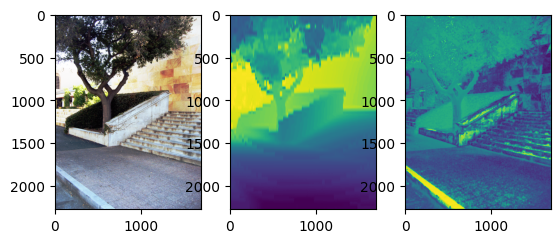

mean:102.83961153954242
var:2143.096139796531
max:254


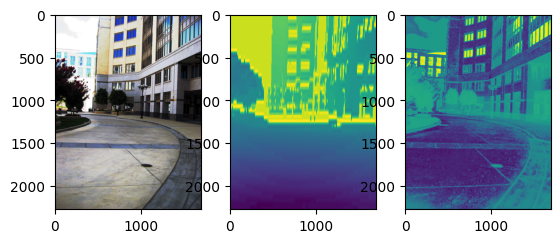

mean:116.58720161343649
var:3354.0444265190304
max:254


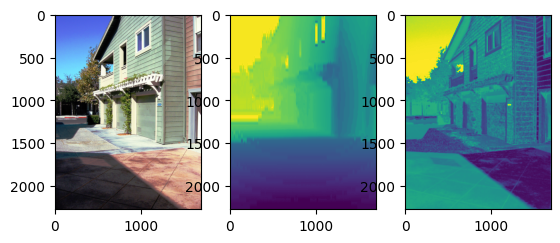

mean:103.85793343541295
var:1512.060921049186
max:249


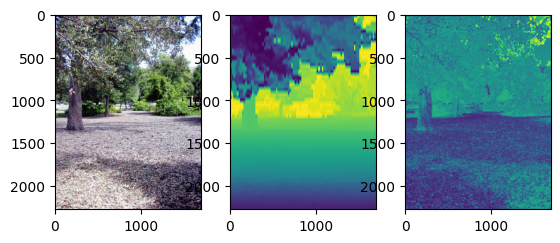

mean:105.1507092363453
var:2238.929288901986
max:245


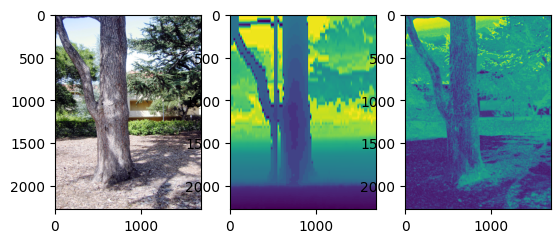

mean:115.51304821298685
var:5761.960301273432
max:254


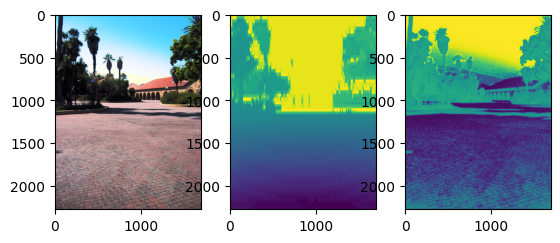

mean:107.2853843276797
var:2239.0620876781622
max:252


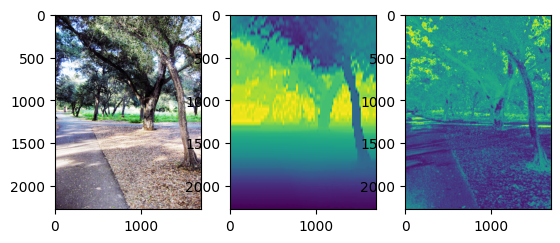

mean:104.34598324985122
var:2053.6057892511412
max:246


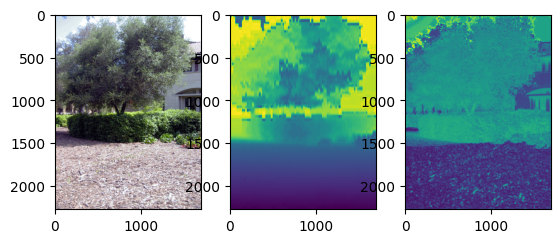

In [119]:
compareResults(encoder_decoder,val_dataloader,num_batches=2)

In [129]:
model = torch.load("./models/saved/default_model.pth",weights_only=False)
model.eval()
print(model)
print(hasattr(model,'encoder_conv1'))

compareResults(model,val_dataloader)

EncoderDecoder(
  (Encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(24, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv4): Sequential(
      (0): Conv2d(36, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv5): Sequential(
      (0): Conv2d(48, 

AttributeError: 'EncoderDecoder' object has no attribute 'encoder_conv1'

In [35]:
from datasets import load_dataset

nyu_depth_dataset = load_dataset("sayakpaul/nyu_depth_v2",trust_remote_code=True)
# example = nyu_depth_dataset[index]

# example['image']

Loading dataset shards:   0%|          | 0/127 [00:01<?, ?it/s]

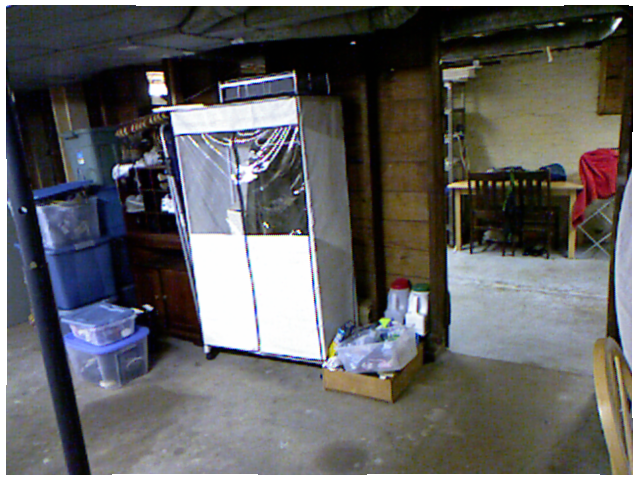

In [ ]:
nyu_depth_dataset['train'][0]['image']

In [45]:
def colored_depthmap(depth, d_min=None, d_max=None):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * plt.cm.viridis(depth_relative)[:,:,:3]

def show_depthmap(depth_map):
   if not isinstance(depth_map, np.ndarray):
       depth_map = np.array(depth_map)
   if depth_map.ndim == 3:
       depth_map = depth_map.squeeze()

   d_min = np.min(depth_map)
   d_max = np.max(depth_map)
   depth_map = colored_depthmap(depth_map, d_min, d_max)

   plt.imshow(depth_map.astype("uint8"))
   plt.axis("off")
   plt.show()


(480, 640)


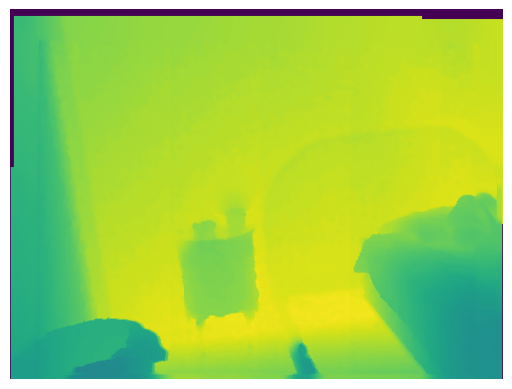

In [112]:
depth = nyu_depth_dataset['train'][9118]['depth_map']
print(np.shape(depth))
show_depthmap(depth)